In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [52]:
!pip install transformers

In [53]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import shutil
import sys


In [54]:
train_path="../input/feedback-prize-english-language-learning/train.csv"
test_path="../input/feedback-prize-english-language-learning/test.csv"

In [55]:
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [56]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [57]:
train_df.drop(['syntax',	'vocabulary','phraseology','grammar','conventions','text_id'],axis=1,inplace=True)

In [58]:
train_df.head()

,full_text,cohesion
0,I think that students would benefit from learn...,3.5
1,When a problem is a change you have to let it ...,2.5
2,"Dear, Principal\n\nIf u change the school poli...",3.0
3,The best time in life is when you become yours...,4.5
4,Small act of kindness can impact in other peop...,2.5


In [59]:
train_df.cohesion.unique()

array([3.5, 2.5, 3. , 4.5, 4. , 2. , 1. , 5. , 1.5])

In [60]:
train_df.shape

(3911, 2)

<Figure size 576x432 with 0 Axes>

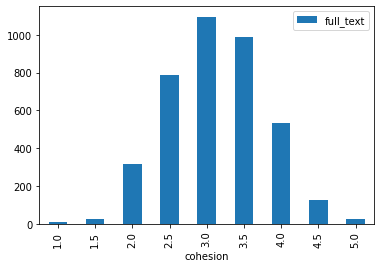

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_df.groupby('cohesion').count().plot.bar(ylim=0)
plt.show()

In [62]:
train_df.head()

,full_text,cohesion
0,I think that students would benefit from learn...,3.5
1,When a problem is a change you have to let it ...,2.5
2,"Dear, Principal\n\nIf u change the school poli...",3.0
3,The best time in life is when you become yours...,4.5
4,Small act of kindness can impact in other peop...,2.5


In [63]:
MAX_LEN=256
TRAIN_BATCH_SIZE=32
VALID_BATCH_SIZE=32
EPOCHS=2
LEARNING_RATE=1e-05


In [64]:
from transformers import BertTokenizer,BertModel

In [65]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")

In [66]:
example_text="I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home."

In [67]:
encodings=tokenizer.encode_plus(
    example_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
    
    
    )

In [68]:
encodings

{'input_ids': tensor([[ 101, 1045, 2228, 2008, 2493, 2052, 5770, 2013, 4083, 2012, 2188, 1010,
         2138, 2027, 2180, 2102, 2031, 2000, 2689, 1998, 2131, 2039, 2220, 1999,
         1996, 2851, 2000, 6457, 1998, 2079, 2045, 2606, 1012, 2635, 2069, 4280,
         7126, 2068, 2138, 2012, 2045, 2160, 2027, 1005, 2222, 2022, 3477, 2062,
         3086, 1012, 2027, 2097, 2022, 6625, 2012, 2188, 1012,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,

In [69]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self,df,tokenizer,max_len):
    self.df=df
    self.tokenizer=tokenizer
    self.max_len=max_len
    self.title=self.df['full_text']
    self.targets=self.df['cohesion'].values
  def __len__(self):
    return len(self.title)
  def __getitem__(self,index):
    title=str(self.title[index])
    title=" ".join(title.split())

    inputs=self.tokenizer.encode_plus(
        title,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        return_token_type_ids=True,
        trunction=True,
        return_attention_mask=True,
        return_tensors='pt'



    )
    return {
        'input_ids':inputs['input_ids'].flatten(),
        'attention_mask':input['attention_mask'].flatten(),
        'token_type_ids':input['token_type_ids'].flatten(),
        'targets':torch.FloatTensor(self.targets[index])
    }

  

In [70]:
train_size=0.8
train_df=train_df.sample(frac=train_size,random_state=200).reset_index(drop=True)
val_df=train_df.drop(train_df.index).reset_index(drop=True)

In [71]:
train_dataset=CustomDataset(train_df,tokenizer,MAX_LEN)

In [72]:
val_dataset=CustomDataset(val_df,tokenizer,MAX_LEN)

In [73]:
train_data_loader=torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=0
)


val_data_loader=torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=VALID_BATCH_SIZE,
    num_workers=0
)

In [74]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [77]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [78]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 6)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [79]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [80]:
val_targets=[]
val_outputs=[]

In [81]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model